# Voronoi

The `voronoi` module finds the [Voronoi diagram](https://en.wikipedia.org/wiki/Voronoi_diagram) of a set of points, **while respecting periodic boundary conditions** (which are not handled by [`scipy.spatial.Voronoi`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Voronoi.html)). This is handled by replicating the points using periodic images that lie outside the box, up to a specified buffer distance.

This case is two-dimensional (with z=0 for all particles) for simplicity, but the `voronoi` module works for both 2D and 3D simulations.

In [1]:
import numpy as np
import freud
import matplotlib
import matplotlib.pyplot as plt

First, we generate some sample points.

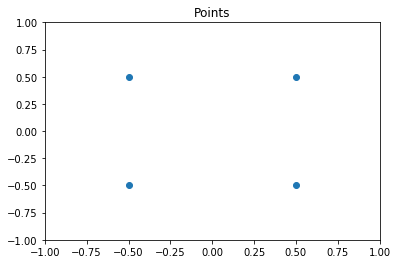

In [2]:
points = np.array([
    [-0.5, -0.5],
    [0.5, -0.5],
    [-0.5, 0.5],
    [0.5, 0.5]])
plt.scatter(points[:,0], points[:,1])
plt.title('Points')
plt.xlim((-1, 1))
plt.ylim((-1, 1))
plt.show()

# We must add a z=0 component to this array for freud
points = np.hstack((points, np.zeros((points.shape[0], 1))))

Now we create a box and a `voronoi` compute object. Note that the buffer distance must be large enough to ensure that the points are duplicated sufficiently far outside the box for the `qhull` algorithm. **Results are only guaranteed to be correct when `buffer` >= L/2, for the longest box side length L.**

In [3]:
L = 2
box = freud.box.Box.square(L)
voro = freud.voronoi.Voronoi(box, L/2)

Next, we use the `compute` method to determine the Voronoi polytopes (cells) and the `polytopes` property to return their coordinates. Note that we use `freud`'s *method chaining* here, where a compute method returns the compute object.

In [4]:
cells = voro.compute(box=box, positions=points).polytopes
print(cells)

[array([[ 0., -1.,  0.],
       [-1., -1.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  0.,  0.]]), array([[ 0., -1.,  0.],
       [ 0.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1., -1.,  0.]]), array([[-1.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  1.,  0.],
       [-1.,  1.,  0.]]), array([[0., 0., 0.],
       [0., 1., 0.],
       [1., 1., 0.],
       [1., 0., 0.]])]


/Users/bdice/anaconda3/envs/dice/lib/python3.6/site-packages/ipykernel_launcher.py:1: FreudDeprecationWarning: The getBufferParticles function is deprecated in favor of the buffer_particles class attribute and will be removed in a future version of freud.
  """Entry point for launching an IPython kernel.
/Users/bdice/anaconda3/envs/dice/lib/python3.6/site-packages/ipykernel_launcher.py:1: FreudDeprecationWarning: The getBufferIds function is deprecated in favor of the buffer_ids class attribute and will be removed in a future version of freud.
  """Entry point for launching an IPython kernel.


We create a helper function to draw the Voronoi polygons using `matplotlib`.

In [5]:
def draw_voronoi(box, points, cells, nlist=None, color_by_sides=False):
    ax = plt.gca()
    # Draw Voronoi cells
    patches = [plt.Polygon(cell[:, :2]) for cell in cells]
    patch_collection = matplotlib.collections.PatchCollection(patches, edgecolors='black', alpha=0.4)
    cmap = plt.cm.viridis
    if color_by_sides:
        colors = [len(cell) for cell in voro.polytopes]
    else:
        colors = np.random.permutation(np.arange(len(patches)))
    patch_collection.set_array(np.array(colors))
    ax.add_collection(patch_collection)

    # Draw points
    plt.scatter(points[:,0], points[:,1], c=colors)
    plt.title('Voronoi Diagram')
    plt.xlim((-box.Lx/2, box.Lx/2))
    plt.ylim((-box.Ly/2, box.Ly/2))
    
    # Set equal aspect and draw box
    ax.set_aspect('equal', 'datalim')
    box_patch = plt.Rectangle([-box.Lx/2, -box.Ly/2], box.Lx, box.Ly, alpha=1, fill=None)
    ax.add_patch(box_patch)
    
    # Draw neighbor lines
    if nlist is not None:
        bonds = np.asarray([points[j] - points[i] for i, j in zip(nlist.index_i, nlist.index_j)])
        box.wrap(bonds)
        line_data = np.asarray([[points[nlist.index_i[i]],
                                 points[nlist.index_i[i]]+bonds[i]] for i in range(len(nlist.index_i))])
        line_data = line_data[:, :, :2]
        line_collection = matplotlib.collections.LineCollection(line_data, alpha=0.3)
        ax.add_collection(line_collection)
    
    # Show colorbar for number of sides
    if color_by_sides:
        plt.colorbar()
    plt.show()

Now we can draw the Voronoi diagram from the example above.

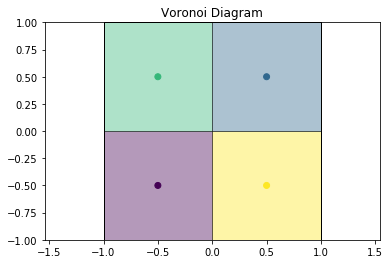

In [6]:
draw_voronoi(box, points, voro.polytopes)

This also works for more complex cases, such as this hexagonal lattice.

/Users/bdice/anaconda3/envs/dice/lib/python3.6/site-packages/ipykernel_launcher.py:22: FreudDeprecationWarning: The getBufferParticles function is deprecated in favor of the buffer_particles class attribute and will be removed in a future version of freud.
/Users/bdice/anaconda3/envs/dice/lib/python3.6/site-packages/ipykernel_launcher.py:22: FreudDeprecationWarning: The getBufferIds function is deprecated in favor of the buffer_ids class attribute and will be removed in a future version of freud.


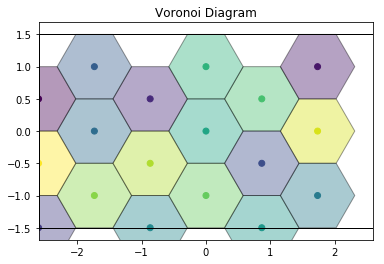

In [7]:
def hexagonal_lattice(rows=3, cols=3, noise=0):
    # Assemble a hexagonal lattice
    points = []
    for row in range(rows*2):
        for col in range(cols):
            x = (col + (0.5 * (row % 2)))*np.sqrt(3)
            y = row*0.5
            points.append((x, y, 0))
    points = np.asarray(points)
    points += np.random.multivariate_normal(mean=np.zeros(3), cov=np.eye(3)*noise, size=points.shape[0])
    # Set z=0 again for all points after adding Gaussian noise
    points[:, 2] = 0

    # Wrap the points into the box
    box = freud.box.Box(Lx=cols*np.sqrt(3), Ly=rows, is2D=True)
    points = box.wrap(points)
    return box, points

# Compute the Voronoi diagram and plot
box, points = hexagonal_lattice()
voro = freud.voronoi.Voronoi(box, np.max(box.L)/2)
voro.compute(box=box, positions=points)
draw_voronoi(box, points, voro.polytopes)

For noisy data, we see that the Voronoi diagram can change substantially. We perturb the positions with 2D Gaussian noise:

/Users/bdice/anaconda3/envs/dice/lib/python3.6/site-packages/ipykernel_launcher.py:3: FreudDeprecationWarning: The getBufferParticles function is deprecated in favor of the buffer_particles class attribute and will be removed in a future version of freud.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/bdice/anaconda3/envs/dice/lib/python3.6/site-packages/ipykernel_launcher.py:3: FreudDeprecationWarning: The getBufferIds function is deprecated in favor of the buffer_ids class attribute and will be removed in a future version of freud.
  This is separate from the ipykernel package so we can avoid doing imports until


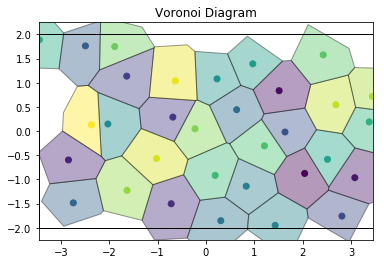

In [8]:
box, points = hexagonal_lattice(rows=4, cols=4, noise=0.04)
voro = freud.voronoi.Voronoi(box, np.max(box.L)/2)
voro.compute(box=box, positions=points)
draw_voronoi(box, points, voro.polytopes)

If we color by the number of sides of each Voronoi cell, we can see patterns in the defects: 5-gons and 7-gons tend to pair up.

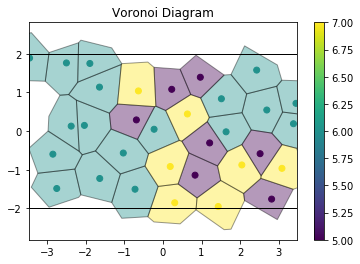

In [9]:
draw_voronoi(box, points, voro.polytopes, color_by_sides=True)

We can also compute the volumes of the Voronoi cells. Here, we plot them as a histogram:

/Users/bdice/anaconda3/envs/dice/lib/python3.6/site-packages/ipykernel_launcher.py:1: FreudDeprecationWarning: The getBuffer function is deprecated in favor of the buffer class attribute and will be removed in a future version of freud.
  """Entry point for launching an IPython kernel.


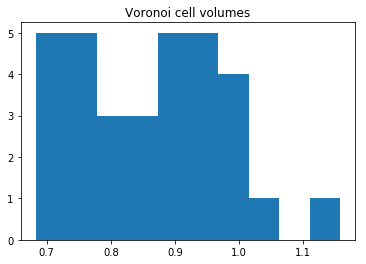

In [10]:
voro.computeVolumes()
plt.hist(voro.volumes)
plt.title('Voronoi cell volumes')
plt.show()

The `voronoi` module also provides `freud.locality.NeighborList` objects, where particles are neighbors if they share an edge in the Voronoi diagram. The `NeighborList` effectively represents the bonds in the [Delaunay triangulation](https://en.wikipedia.org/wiki/Delaunay_triangulation).

/Users/bdice/anaconda3/envs/dice/lib/python3.6/site-packages/ipykernel_launcher.py:1: FreudDeprecationWarning: The getBufferParticles function is deprecated in favor of the buffer_particles class attribute and will be removed in a future version of freud.
  """Entry point for launching an IPython kernel.
/Users/bdice/anaconda3/envs/dice/lib/python3.6/site-packages/ipykernel_launcher.py:1: FreudDeprecationWarning: The getBufferIds function is deprecated in favor of the buffer_ids class attribute and will be removed in a future version of freud.
  """Entry point for launching an IPython kernel.


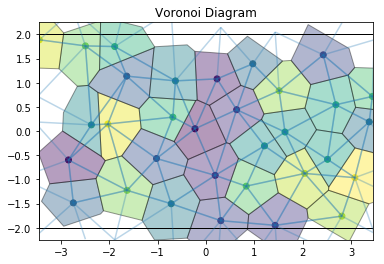

In [11]:
voro.computeNeighbors(box=box, positions=points)
nlist = voro.nlist
draw_voronoi(box, points, voro.polytopes, nlist=nlist)

The `voronoi` property stores the raw `scipy.spatial.qhull.Voronoi` object from `scipy`.

**Important:** The plots below also show the *replicated buffer points*, not just the ones inside the periodic box. `freud.voronoi` is intended for use with periodic systems while `scipy.spatial.Voronoi` does not recognize periodic boundaries.

<class 'scipy.spatial.qhull.Voronoi'>


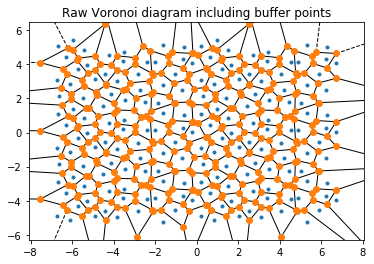

In [12]:
print(type(voro.voronoi))
from scipy.spatial import voronoi_plot_2d
voronoi_plot_2d(voro.voronoi)
plt.title('Raw Voronoi diagram including buffer points')
plt.show()